# Import packages

In [144]:
import pandas as pd
import json
import requests
from bs4 import BeautifulSoup
import csv
import regex as re
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx 
from collections import Counter
from fa2 import ForceAtlas2
from Functions import DataCollection, DataCleaning, GetConnectedMoviesArtist
from imdb import IMDb
import community.community_louvain as cl
import community
import numpy as np 

# Colors 

In [ ]:
one_color = []
two_colors = []
three_ratings_colors = []


In [154]:
color_palette_cividis = sns.color_palette("viridis", 12)[1:-2]
color_palette_plasma = sns.color_palette("plasma", 12)[1:]
color_palette_cividis_reversed = list(reversed(color_palette_cividis))
color_palette = color_palette_cividis_reversed + color_palette_plasma
plt.figure(figsize = (20,2))
plt.imshow([color_palette])
plt.axis('off')
plt.show()

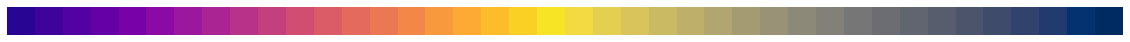

In [156]:
color_palette_cividis = sns.color_palette("cividis", 20)
color_palette_plasma = sns.color_palette("plasma", 20)
color_palette_cividis_reversed = list(reversed(color_palette_cividis))
color_palette = color_palette_plasma + color_palette_cividis_reversed
plt.figure(figsize = (20,2))
plt.imshow([color_palette])
plt.axis('off')
plt.show()

# Data Collection 

In [87]:
# params = {
#         "thriller": {"years": ["2020s","2010s", "2000s"],
#                 "sub_years": [["2020", "2021", "2022"],["2010", "2011", "2012","2013","2014","2015","2016","2017","2018","2019"],[[]]]}, 
#         "action": {"years": ["2020s","2010s", "2000s"],
#                 "sub_years": [["2020", "2021", "2022"],["2010", "2011", "2012","2013","2014","2015","2016","2017","2018","2019"],["2000", "2001", "2002","2003","2004","2005","2006","2007","2008","2009"]]},             
#         "comedy": {"years": ["2020s","2010s", "2000s"],
#                 "sub_years": [["2020", "2021", "2022"],["2010", "2011", "2012","2013","2014","2015","2016","2017","2018","2019"],["2000", "2001", "2002","2003","2004","2005","2006","2007"]]},
#         "adventure": {"years": ["2020s","2010s", "2000s"],
#                 "sub_years": [["2020", "2021", "2022", "2023"], ["2010", "2011", "2012","2013","2014","2015","2016","2017","2018","2019"], ["2000", "2001", "2002","2003","2004","2005","2006","2007","2008","2009"]]}, 
#         "horror": {"years": ["2020", "2021", "2022", "2010","2011","2012","2013","2014","2015","2016","2017","2018","2019", "2000", "2001", "2002","2003","2004","2005","2006","2007","2008","2009"], 
#                 "sub_years": [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]},
#         "fantasy": {"years": ["2020s","2010s", "2000s"],
#                 "sub_years": [[[]],[[]],[[]]]}, 
#         "science_fiction": {"years": ["2020s", "2010s", "2000s"],
#                 "sub_years": [[[]],[[]],[[]]]}, 
#         }

# data_collection = DataCollection()
# data_movie_artist = pd.DataFrame()
# for genre in params.keys():
#     for years, sub_years in zip(params[genre]["years"],params[genre]["sub_years"]):
#         data = data_collection.collect_movies_artist_data(genre, years, sub_years)
#         data_movie_artist = pd.concat([data_movie_artist, data]) 

# data_movie_artist = data_movie_artist.reset_index(drop=True)

In [88]:
data_movie_artist = pd.read_json('data_movie_artist.json', orient='table')
data_movie_artist.shape

(7456, 7)

# Data Cleaning

In [89]:
# data_cleaner = DataCleaning(data_movie_artist)
# data_cleaner.data_cleaning()
# df_movies = data_cleaner.data

In [90]:
df_movies = pd.read_json('df_movies.json', orient='table')
df_movies.shape

(5780, 7)

# Get Ratings

In [ ]:
# # Initialize the IMDb object
# ia = IMDb()

# # Function to get movie rating
# def get_movie_rating(title):
#     try:
#         movie = ia.search_movie(title)[0]  # Assume the first search result is the correct movie
#         ia.update(movie)
#         return movie.data['rating']
#     except Exception as e:
#         return None

# # Add a new column to the DataFrame with the ratings
# df_movies['Rating'] = df_movies['Title'].apply(get_movie_rating)

In [162]:
df_movies_ratings = pd.read_json('with_ratings.json', orient='table')
df_movies_ratings.shape

(5780, 8)

In [163]:
# Movies without rating
print(df_movies_ratings['Rating'].isnull().sum())
# we drop them
df_movies_ratings = df_movies_ratings.dropna()

428


In [181]:
percentile_25 = df_movies_ratings['Rating'].quantile(0.25) 
print(percentile_25)
percentile_75 = df_movies_ratings['Rating'].quantile(0.75)
print(percentile_75)

5.2
6.8


In [182]:
# Function to apply the conditions
def label_rating(row):
    if row < percentile_25:
        return 'Low'
    elif row >= percentile_75:
        return 'High'
    else:
        return 'Moderate'

# Apply the function to create a new column
df_movies_ratings['RatingLabel'] = df_movies_ratings['Rating'].apply(label_rating)

In [186]:
df_movies_ratings = pd.read_json('df_movies_ratings.json', orient='table')
df_movies_ratings.shape

(5352, 9)

In [187]:
df_movies_ratings.head(2)

Title                       Director  \
0  365 Days  barbara biaowas tomasz mandes   
1      7500               patrick vollrath   

                                                Cast Country     Genre  Year  \
0  anna-maria sieklucka,michele morrone, bronisaw...  europe  Thriller  2020   
1                   joseph gordon-levitt,aylin tezel     mix    Action  2020   

               Hyperref  Rating RatingLabel  
0  365_Days_(2020_film)     3.3         Low  
1           7500_(film)     6.3    Moderate

In [184]:
df_movies_ratings['RatingLabel'].value_counts()

Moderate    2711
High        1416
Low         1225
Name: RatingLabel, dtype: int64

# Get connected Movies and Artists

In [100]:
# get_connected_movies_artists = GetConnectedMoviesArtist()
# connected_movies = get_connected_movies_artists.connected_movies_and_cast(df_movies_ratings)
# with open('connected_movies_and_casts.json', 'w') as file:
#     json.dump(connected_movies, file, indent=4)

In [103]:
with open('connected_movies_and_casts.json', 'r') as file:
    connected_movies = json.load(file)

In [104]:
len(connected_movies.keys())

5352

# Basic Statistics

### Genre distribution

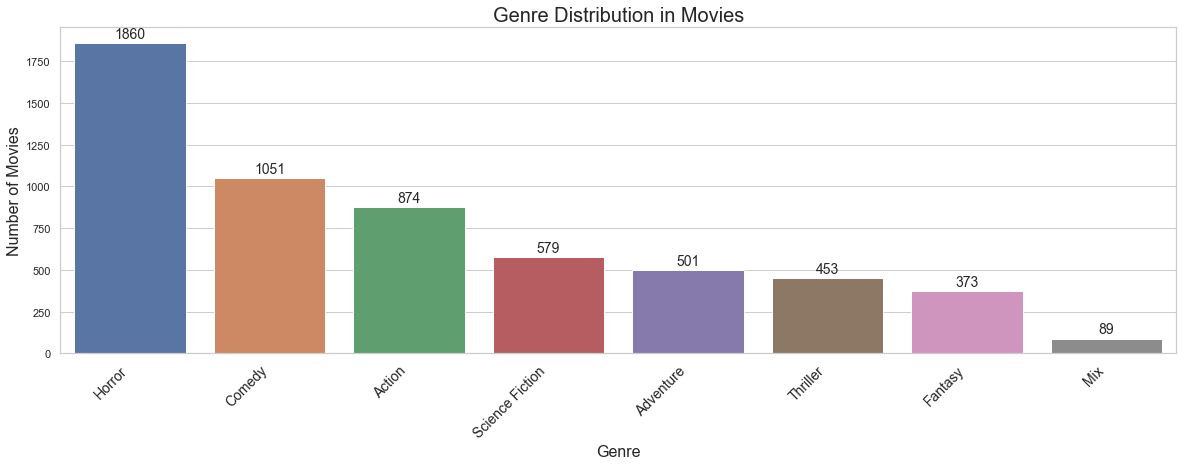

In [12]:
genre_counts = df_movies['Genre'].value_counts()
genre_counts = genre_counts.reset_index()
genre_counts.columns = ['Genre', 'Count']

# Create the bar plot
sns.set(style="whitegrid") 
plt.figure(figsize=(20, 6)) 
barplot = sns.barplot(x='Genre', y='Count', data=genre_counts)

# Rotate the labels on x-axis for better readability
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.title('Genre Distribution in Movies', fontsize=20)
plt.xlabel('Genre', fontsize=16)
plt.ylabel('Number of Movies', fontsize=16)

# Add count numbers on each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points',
                     fontsize=14)
plt.show()

### Movies over time 

In [13]:
df_movies['Year'] = pd.to_numeric(df_movies['Year'], errors='coerce')
movies_per_year = df_movies.groupby('Year').size()
movies_per_year = movies_per_year.reset_index()
movies_per_year.columns = ['Year', 'Number of Movies']

# Create the bar plot
sns.set(style="whitegrid")
plt.figure(figsize=(20, 6))
barplot = sns.barplot(x='Year', y='Number of Movies', data=movies_per_year)
plt.xticks(fontsize=14)
plt.title('Number of Movies Over Time', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Movies', fontsize=16)

# Add count numbers on each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points',
                     fontsize=14)
plt.show()

### Country distribution

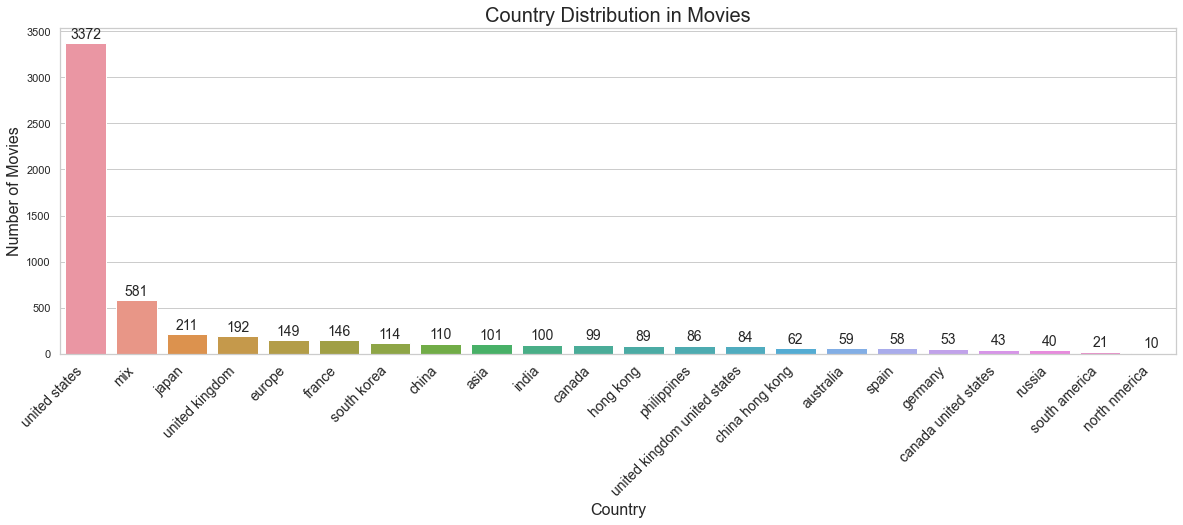

In [14]:
genre_counts = df_movies['Country'].value_counts()
genre_counts = genre_counts.reset_index()
genre_counts.columns = ['Country', 'Count']

# Create the bar plot
sns.set(style="whitegrid") 
plt.figure(figsize=(20, 6)) 
barplot = sns.barplot(x='Country', y='Count', data=genre_counts)

# Rotate the labels on x-axis for better readability
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.title('Country Distribution in Movies', fontsize=20)
plt.xlabel('Country', fontsize=16)
plt.ylabel('Number of Movies', fontsize=16)

# Add count numbers on each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points',
                     fontsize=14)
plt.show()

# Network Science

In [122]:
# Create undirected Graph
G_movies = nx.Graph()

# Adding nodes
movies_nodes = list(connected_movies.keys())
G_movies.add_nodes_from(movies_nodes)

node_attr = df_movies_ratings[['Title','Director','Cast','Country','Genre', 'Rating',
                'Year']].set_index('Title').to_dict('index') # Creating a dictionary with the characters and their attributes

nx.set_node_attributes(G_movies, node_attr) #Adding attributes to the graph

for movie in connected_movies.keys():
    for connected_movie in connected_movies[movie]: 
        weight = len(connected_movies[movie][connected_movie])
        attribute_value = connected_movies[movie][connected_movie]
        G_movies.add_edges_from([(movie, connected_movie)], weight=weight, attribute_name=attribute_value)

In [134]:
G_movies

In [123]:
print(G_movies.edges["365 Days: This Day", "365 Days"])

{'weight': 3, 'attribute_name': ['magdalena lamparska', 'michele morrone', 'anna-maria sieklucka']}


In [124]:
print(G_movies.nodes["365 Days: This Day"])

{'Director': 'barbara biaowas,tomasz mandes', 'Cast': 'anna-maria sieklucka,michele morrone, rebecca casiraghi,magdalena lamparska', 'Country': 'europe', 'Genre': 'Thriller', 'Rating': 2.6, 'Year': '2022'}


# Network Analysis

In [125]:
print("The network consist of: ", G_movies.number_of_nodes(), " nodes (Movies)")
print("The network consist of: ", G_movies.number_of_edges(), " edges")

The network consist of:  5352  nodes (Movies)
The network consist of:  34122  edges


## Largest Connected Component

In [126]:
#Extracting the largest component
connected_components = nx.connected_components(G_movies)
# Finding the largest connected component
largest_cc = max(connected_components, key=len)
# Creating a subgraph for the largest connected component
G_largest_cc = G_movies.subgraph(largest_cc).copy()

In [127]:
print("The largest connected component network consist of: ", G_largest_cc.number_of_nodes(), " nodes (Movies)")
print("The largest connected component network consist of: ", G_largest_cc.number_of_edges(), " edges")

The largest connected component network consist of:  4029  nodes (Movies)
The largest connected component network consist of:  33730  edges


# Assortativity analysis 

In [128]:
nx.degree_assortativity_coefficient(G_largest_cc)

0.33712467636528853

In [133]:
nx.attribute_assortativity_coefficient(G_largest_cc, 'Cast')

0.001727884672202707

In [129]:
nx.attribute_assortativity_coefficient(G_largest_cc, 'Genre')

0.14011725941445055

In [130]:
nx.attribute_assortativity_coefficient(G_largest_cc, 'Rating')

0.002957407863504599

In [131]:
nx.attribute_assortativity_coefficient(G_largest_cc, 'Country')

0.21080520602473424

In [132]:
nx.attribute_assortativity_coefficient(G_largest_cc, 'Year')

0.004263465314948498

# Communities 

In [137]:
communities = cl.best_partition(G_largest_cc, random_state=42)

In [139]:
print('The algorithm found', len(np.unique(list(communities.values()))), 'communities in total')

The algorithm found 28 communities in total


In [140]:
modularity = community.modularity(communities, G_largest_cc)
print('The value of modularity is:', round(modularity,2))

The value of modularity is: 0.55


In [143]:
community_count

9     311
22    287
0     261
21    232
11    180
4     178
17    175
1     171
18    163
3     158
26    157
13    143
8     140
15    140
5     135
16    124
6     122
10    120
12    120
14    115
25    109
23    105
19     99
7      96
24     68
2      58
20     38
27     24
dtype: int64

In [142]:
# Count number of rappers in each comunity
community_count = pd.Series(list(communities.values())).value_counts()

# Plot the distribution of community with size of nodes
plt.figure(figsize = (16,6))
#plt.bar(community_count.index, community_count.values, color ='blue')
plt.bar(community_count.index, community_count.values, align='center')
# Count the nodes in community
for index, value in zip(community_count.index, community_count.values):
    plt.text(index, value+0.1, str(value), ha='center', va='bottom')

    
plt.ylabel('Number of nodes (rappers) in  each community')
plt.xlabel('Community number')
plt.title('Distribution of nodes (rappers) in the communities', fontweight="bold") #fontsize=16, 
plt.suptitle("Figure 7", fontsize=16, fontweight="bold")
plt.xticks(community_count.index)

plt.show()

ImportError: cannot import name '_png' from 'matplotlib' (/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py)

<Figure size 1152x432 with 1 Axes>

## Density (average degree)

In [114]:
print("The average degree of the GCC is:", round(sum(dict(G_largest_cc.degree(weight='weight')).values())/len(G_largest_cc.degree)))

The average degree of the GCC is: 17


In [116]:
# Calculating degrees for each node
degrees = [G_largest_cc.degree(n, weight='weight') for n in G_largest_cc.nodes()]

# Convert the degrees list to a DataFrame
degrees_df = pd.DataFrame(degrees, columns=['Degree'])

# Set up the matplotlib figure
# plt.figure(figsize=(24, 6))

# # First subplot for the regular scale histogram
# plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# sns.distplot(degrees_df['Degree'], kde=False, color="#DC2026", hist_kws={'edgecolor':'black'})
# plt.title('Degree Distribution - Linear Scale', fontweight="bold", fontsize=16)
# plt.xlabel('Degree', fontsize=14)
# plt.ylabel('Number of Nodes', fontsize=14)
